# Part 1: Setup & Cleaning

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
import pickle

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.core.display import display, HTML
sns.set()
%matplotlib inline

# Sklearn-preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.utils import class_weight
#from category_encoders import TargetEncoder


# Machine Learning Algorithms
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, IsolationForest,
                              RandomForestRegressor, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import Perceptron


# Performance metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
planets = pd.read_csv('/content/exoplanets.csv', index_col='rowid')
planets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3970 entries, 1 to 3970
Columns: 355 entries, pl_hostname to st_colorn
dtypes: float64(306), int64(25), object(24)
memory usage: 10.8+ MB


In [ ]:
planets.head()

,pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,...,st_bmy,st_bmyerr,st_bmylim,st_m1,st_m1err,st_m1lim,st_c1,st_c1err,st_c1lim,st_colorn
rowid,,,,,,,,,,,,,,,,,,,,,
1,11 Com,b,11 Com b,Radial Velocity,0,1,326.03000,0.32,-0.32,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
2,11 UMi,b,11 UMi b,Radial Velocity,0,1,516.21997,3.20,-3.20,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,14 And,b,14 And b,Radial Velocity,0,1,185.84000,0.23,-0.23,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
4,14 Her,b,14 Her b,Radial Velocity,0,1,1773.40002,2.50,-2.50,0.0,...,0.537,0.001,0.0,0.366,0.002,0.0,0.438,0.006,0.0,9
5,16 Cyg B,b,16 Cyg B b,Radial Velocity,0,1,798.50000,1.00,-1.00,0.0,...,0.418,0.003,0.0,0.222,0.003,0.0,0.351,0.003,0.0,17


In [ ]:
planets.isnull().sum()

pl_hostname          0
pl_letter            0
pl_name              0
pl_discmethod        0
pl_controvflag       0
                  ... 
st_m1lim          3613
st_c1             3613
st_c1err          3614
st_c1lim          3613
st_colorn            0
Length: 355, dtype: int64

### Representation of null values in the dataframes

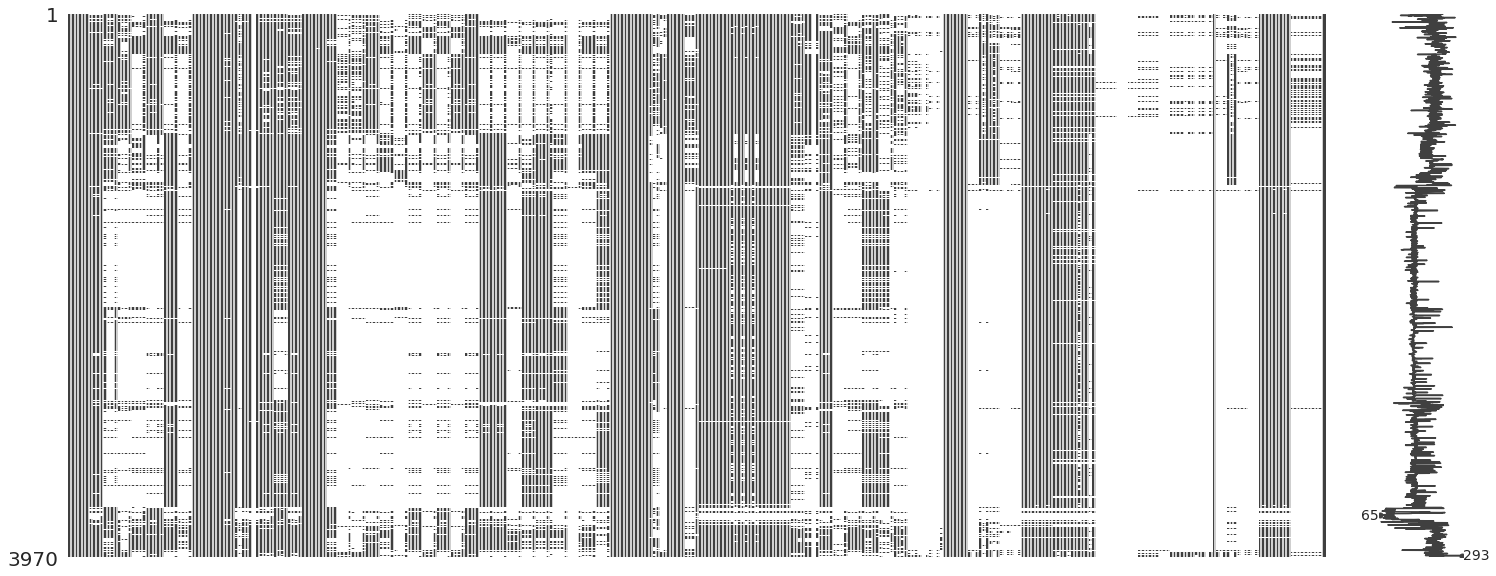

In [ ]:
msno.matrix(planets)
# white indicates missing data

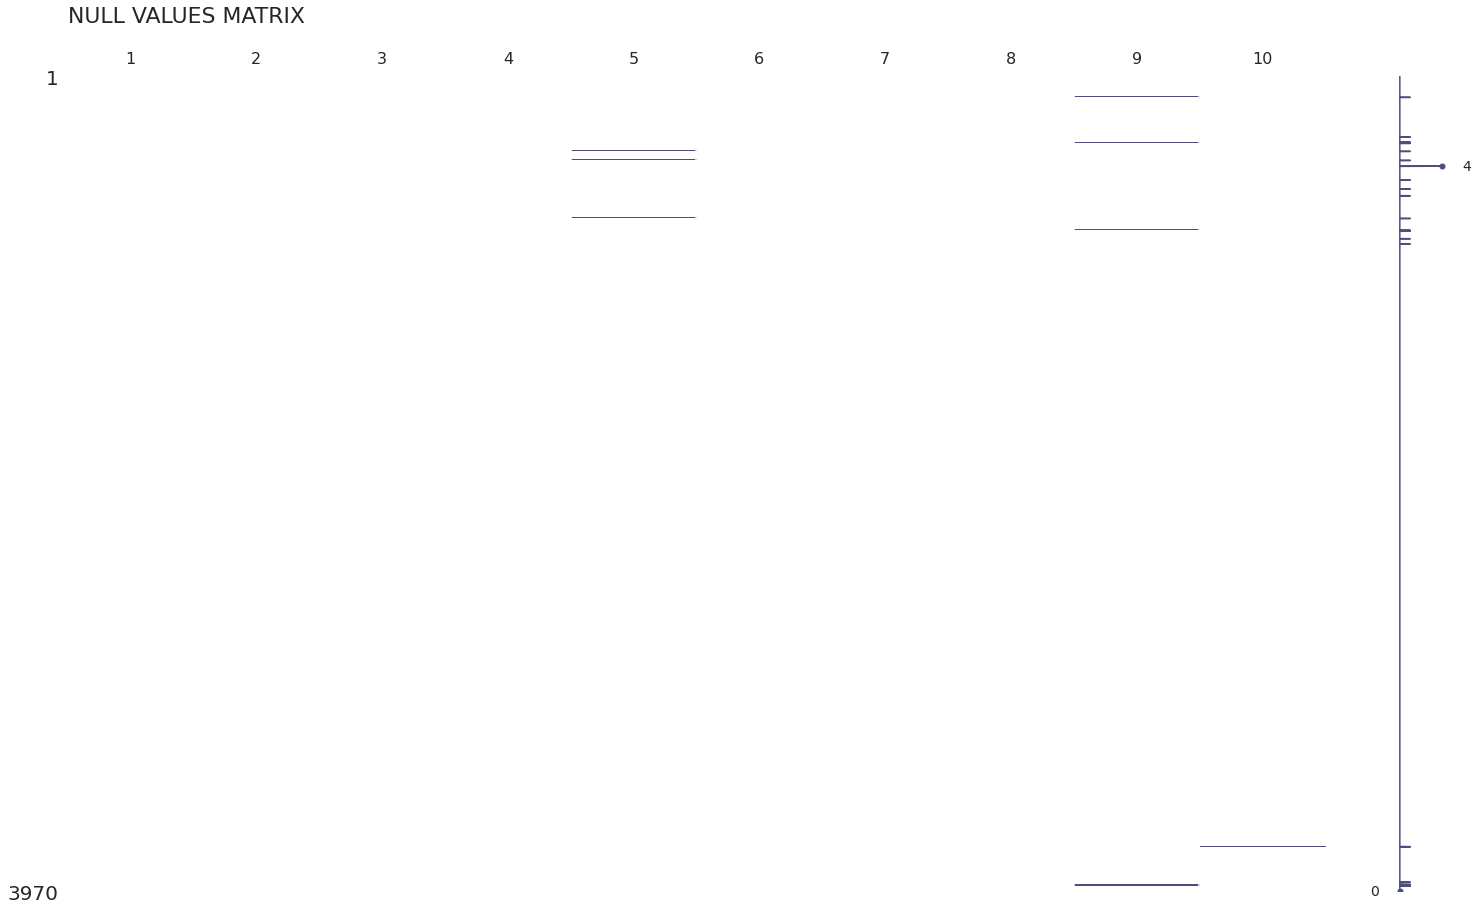

In [ ]:
# defining matrix for the 10 columns with most nulls
mtrx = msno.matrix(planets, figsize=(25,15), filter='bottom',
               n=10, color=(0.3, 0.3, 0.5))
cols = [i.get_text() for i in mtrx.axes.get_xticklabels()]
ticks = np.arange(0, len(cols))

plt.xticks(ticks, labels=ticks+1, rotation=0, ha='center')
plt.title('Null Values Matrix\n'.upper(), loc='left', fontsize=22)
plt.show()

# empty string for the HTML and template for div
html_table = ''
template = '<div style="border-style:solid; display: inline-block; width: 325px; padding-left: 5px; border-width: thin" >{} - {}</div>'

table_order = [1, 5, 8,
               2, 6, 9,
               3, 7, 10,
               4]

for i in table_order:
    html_table += template.format(i, cols[i-1])

HTML(html_table)

## Data Preprocessing 

In [ ]:
hec = pd.read_csv('/content/phl_exoplanet_catalog.csv')
hec.info()
# this is the dataset that holds habitability column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Columns: 112 entries, P_NAME to P_SEMI_MAJOR_AXIS_EST
dtypes: float64(94), int64(4), object(14)
memory usage: 3.5+ MB


In [ ]:
hec.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [ ]:
target_count = hec['P_HABITABLE'].value_counts()
'''
0 --> not habitable
1 --> conservative
2 --> optimistic
'''
target_count

0    3993
2      34
1      21
Name: P_HABITABLE, dtype: int64

In [ ]:
# drop not habitable planets
hec = hec[hec.P_HABITABLE != 0]

In [ ]:
# create habitable column for planets data with the help of hec dataframe
# get names of planets
habitable_planets = hec.P_NAME.values
planets['habitable'] = planets['pl_name'].isin(habitable_planets)

In [ ]:
target_count = planets['habitable'].value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[1] / sum(target_count), 4)*100}')

Class 0: 3921
Class 1: 49
Percentage of Majority Class: 98.77
Percentage of Minority Class: 1.23


So I have an imbalanced dataset, I will deal with it later.

### Handling Missing Data  

In [ ]:
# remove columns with more than 40% missing data
def remove_missing(f):
    count = len(planets[planets[f].isnull()])
    if count/len(planets) > 0.4:
        return 1
    else:
        return 0
    
missing_values = [x for x in planets.columns if remove_missing(x)]
planets = planets.drop(missing_values, axis=1)

In [ ]:
# IterativeImputer
# get only numeric values
numeric_values = planets[planets._get_numeric_data().columns]
imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=76)
numeric_values = pd.DataFrame(imp.fit_transform(numeric_values), columns=numeric_values.columns)
numeric_values.to_csv('Imputed Data.csv', index='rowid')

KeyboardInterrupt: ignored

In [ ]:
imputed_numerics = pd.read_csv('data/Imputed Data.csv')

In [ ]:
# merge imputed data with the planets dataframe
for i in imputed_numerics.columns:
    if i not in planets.columns:
        pass
    else:
        planets[i] = imputed_numerics[i]

In [ ]:
# remove categorical features with more than 10 unique values
cols = [x for x in planets.columns if x not in planets._get_numeric_data().columns]
for i in cols:
    if(len(planets[i].unique()) > 10):
        planets = planets.drop(i, axis=1)

In [ ]:
# also drop these columns too since they are useless to modeling
cols_to_drop = ['pl_letter', 'pl_nnotes', 'pl_disc', 
                'pl_locale', 'pl_status', 'st_nts', 'st_nplc', 'st_nglc', 
                'st_nrvc', 'st_naxa', 'st_nimg', 'st_nspec', 'st_photn', 
                'st_colorn']

planets = planets.drop(cols_to_drop, axis=1)

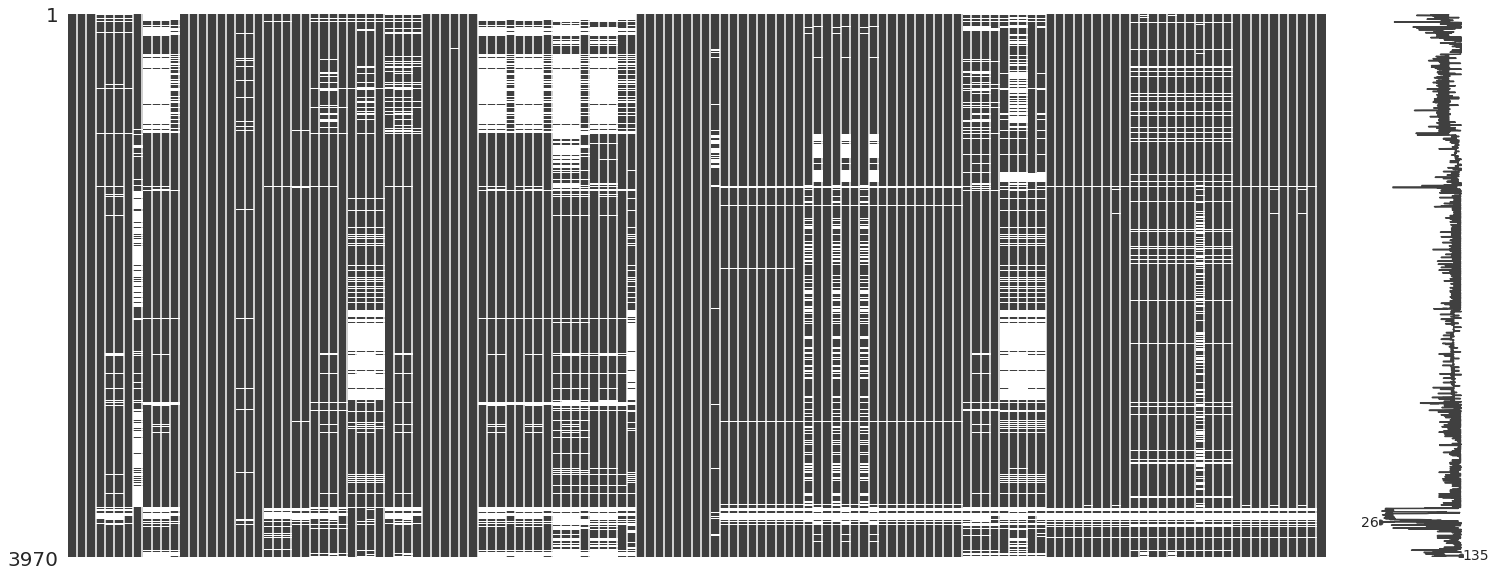

In [ ]:
msno.matrix(planets)

### To Handle Remaining Missing Data 

In [ ]:
# Unique value distribution of categorical features
cat_count = planets['st_optband'].value_counts()
cat_count1 = planets['st_metratio'].value_counts()
print(f'Optical Magnitude Bands:\n{cat_count}')
print('\n')
print(f'Metallicity Ratios:\n{cat_count1}')

Optical Magnitude Bands:
Kepler-band    2300
V (Johnson)    1506
Name: st_optband, dtype: int64


Metallicity Ratios:
[Fe/H]    2730
[M/H]       51
[m/H]       21
Name: st_metratio, dtype: int64


In [ ]:
planets[['st_optband', 'st_metratio']].isnull().sum()

st_optband      164
st_metratio    1168
dtype: int64

In [ ]:
# I fill categorical missing values with most common features because of the difference between their distributions
simp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
planets[['st_optband', 'st_metratio']] = simp.fit_transform(planets[['st_optband', 'st_metratio']])
planets.dropna(how='any', axis=0, inplace=True)

In [ ]:
# Any missing values?
print(planets.isnull().values.any())

False


# Part 2: Visualization & EDA

In [ ]:
planets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 65 to 3957
Columns: 135 entries, pl_discmethod to habitable
dtypes: bool(1), float64(118), int64(13), object(3)
memory usage: 123.5+ KB


In [ ]:
planets.describe()

,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmaxlim,pl_radj,pl_radjerr1,pl_radjerr2,...,st_wise4lim,st_jmh2,st_jmh2err,st_jmh2lim,st_hmk2,st_hmk2err,st_hmk2lim,st_jmk2,st_jmk2err,st_jmk2lim
count,117.000000,117.000000,117.000000,1.170000e+02,1.170000e+02,117.0,117.0,117.000000,117.000000,117.000000,...,117.00000,117.000000,117.000000,117.0,117.000000,117.000000,117.0,117.000000,117.000000,117.0
mean,0.017094,1.581197,19.487381,3.066384e-04,-3.443350e-04,0.0,0.0,0.907889,0.052821,-0.049752,...,-0.65812,0.363650,0.036239,0.0,0.093427,0.034692,0.0,0.457077,0.033162,0.0
std,0.130179,1.176196,76.175193,9.048995e-04,1.263296e-03,0.0,0.0,0.570269,0.052519,0.054658,...,0.47638,0.144139,0.030695,0.0,0.050567,0.019975,0.0,0.181174,0.023441,0.0
min,0.000000,1.000000,0.658524,7.000000e-08,-1.200000e-02,0.0,0.0,0.063000,0.002000,-0.400000,...,-1.00000,-0.034000,0.021000,0.0,-0.013000,0.021000,0.0,-0.024000,0.022000,0.0
25%,0.000000,1.000000,2.684328,3.000000e-06,-1.300000e-04,0.0,0.0,0.261000,0.017000,-0.066000,...,-1.00000,0.270000,0.029000,0.0,0.057000,0.028000,0.0,0.341000,0.027000,0.0
50%,0.000000,1.000000,3.631300,1.100000e-05,-1.100000e-05,0.0,0.0,1.020000,0.034000,-0.034000,...,-1.00000,0.338000,0.031000,0.0,0.087000,0.031000,0.0,0.415000,0.030000,0.0
75%,0.000000,1.000000,7.138048,1.300000e-04,-3.000000e-06,0.0,0.0,1.300000,0.070000,-0.018000,...,0.00000,0.450000,0.035000,0.0,0.126000,0.035000,0.0,0.560000,0.033000,0.0
max,1.000000,5.000000,704.198400,7.000000e-03,-7.000000e-08,0.0,0.0,2.085000,0.300000,-0.001000,...,0.00000,0.705000,0.354000,0.0,0.250000,0.228000,0.0,0.931000,0.273000,0.0


In [ ]:
# most planet numbers in a stellar system
planets['pl_pnum'].nlargest(10)

rowid
2223    5
2634    5
2635    5
2636    5
2637    5
2638    5
1105    4
1106    4
1107    4
1108    4
Name: pl_pnum, dtype: int64

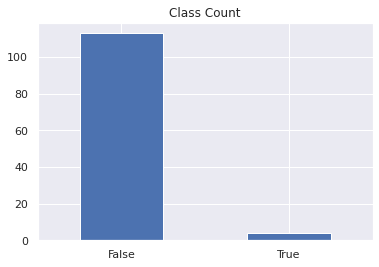

In [ ]:
# target class's distribution
target_count = planets['habitable'].value_counts()
target_count.plot(kind='bar', title='Class Count', rot=0) 

Text(0.5, 1.0, 'Temperature - Mass Relation with Habitability')

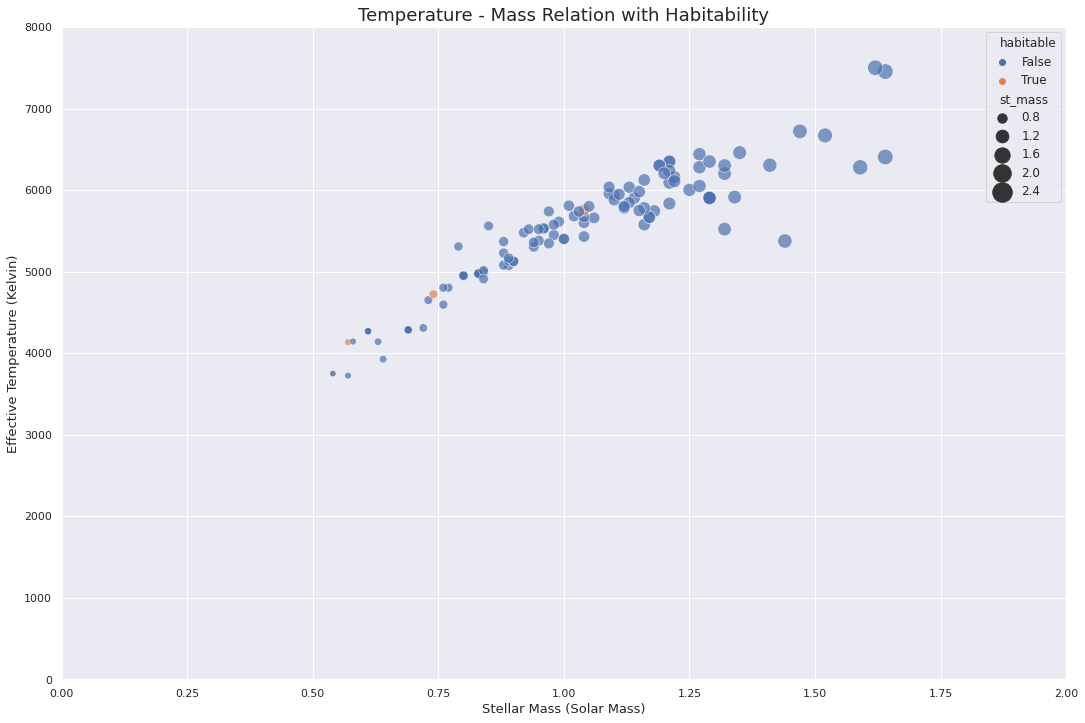

In [ ]:
plt.figure(figsize=(18, 12))
ax = sns.scatterplot(x='st_mass', y='st_teff',
                     hue='habitable', size='st_mass',
                     sizes=(40, 400), alpha=.7,
                     data=planets)
# limiting x and y axis's values
ax.axis([0,2, 0, 8000])
ax.set_xlabel('Stellar Mass (Solar Mass)', fontsize=13)
ax.set_ylabel('Effective Temperature (Kelvin)', fontsize=13)
ax.set_title('Temperature - Mass Relation with Habitability', fontsize=18)

### Distribution of Planets via Dec & Ra


Text(0, 0.5, 'Dec [decimal degrees]')

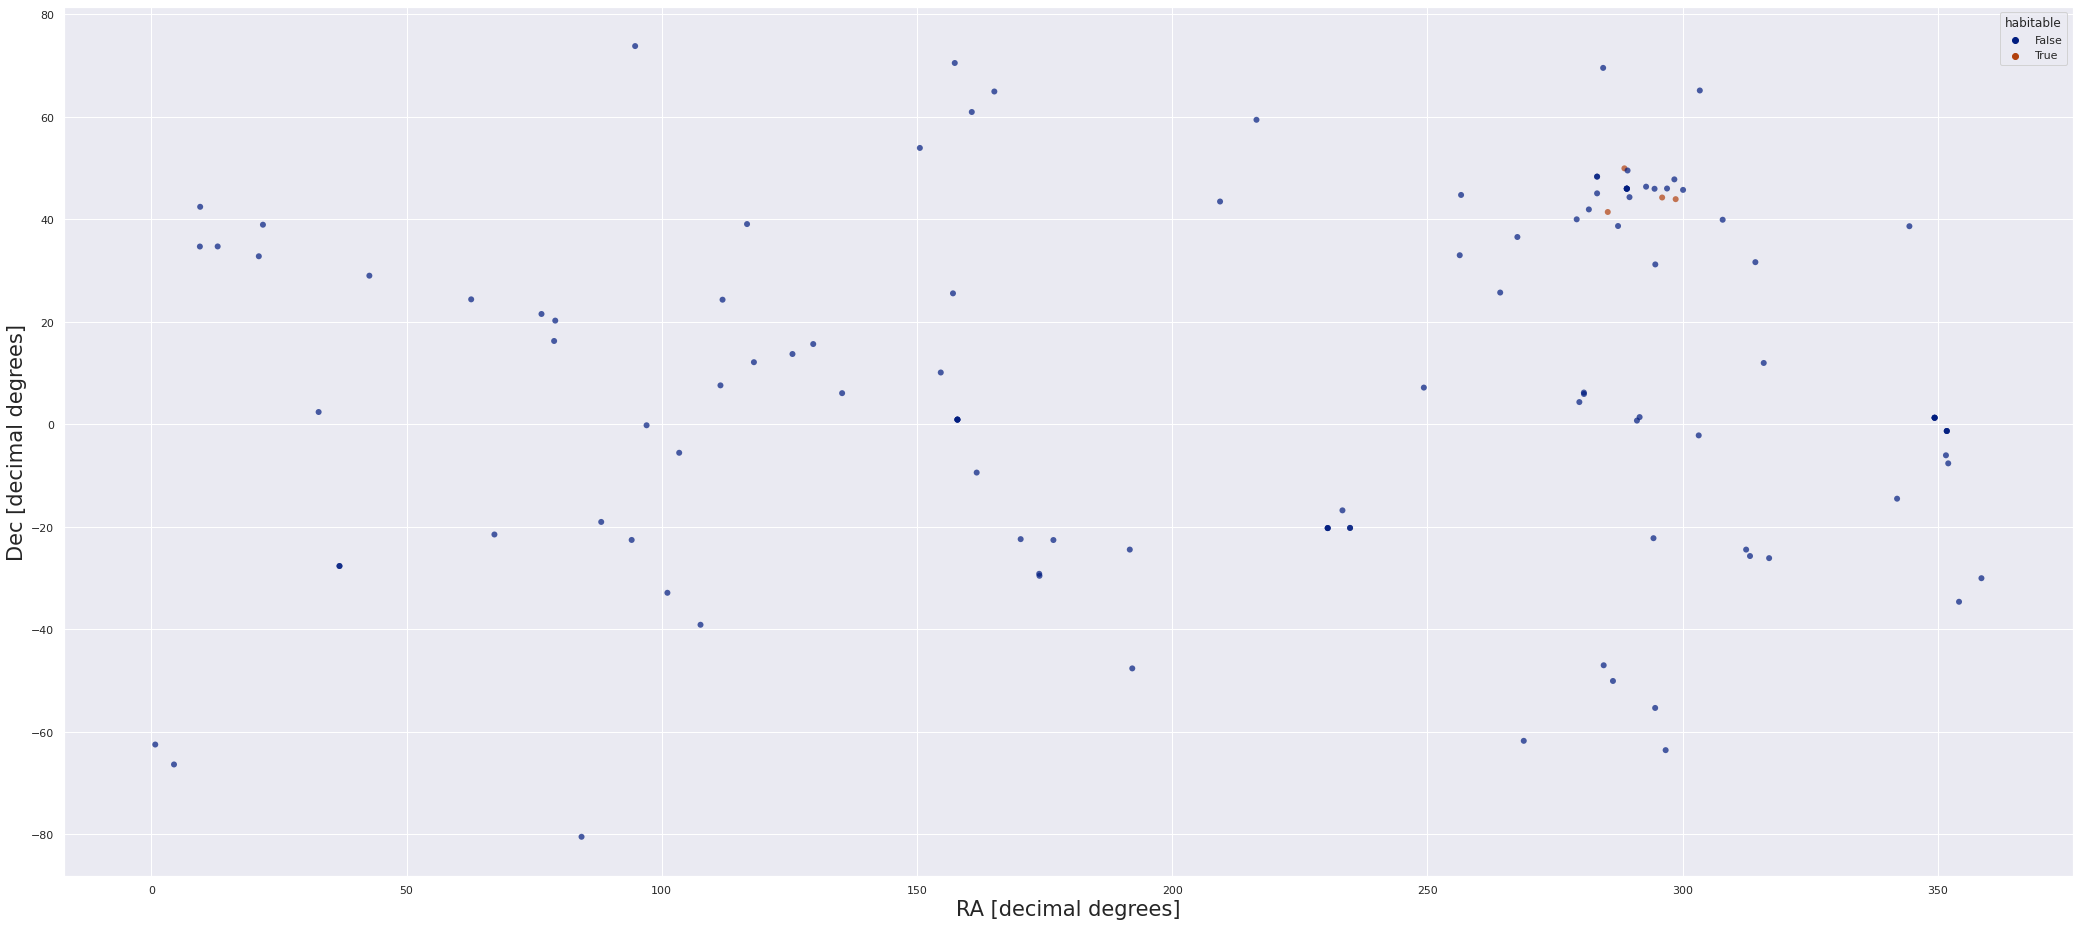

In [ ]:
plt.figure(figsize=(36, 16))
sns.scatterplot(x="ra", y="dec",
                hue="habitable", alpha=.7,
                palette='dark', 
                sizes=(1, 8), linewidth=0,
                data=planets)
plt.xlabel('RA [decimal degrees]', fontsize=21)
plt.ylabel('Dec [decimal degrees]', fontsize=21)

### Visualization of Categorical Features

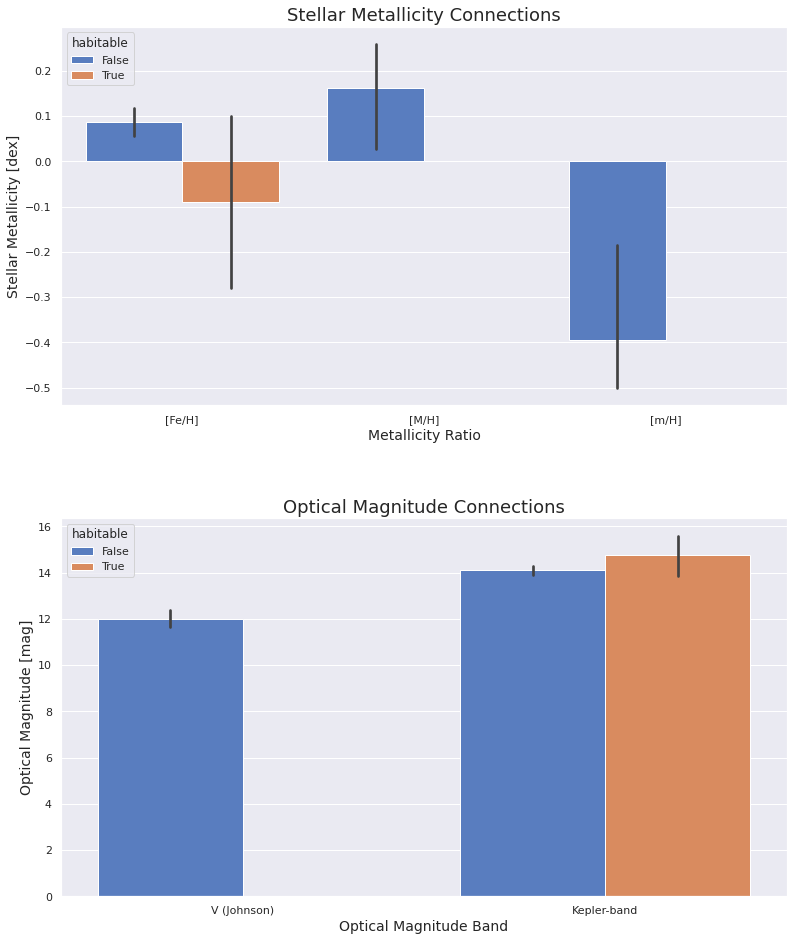

In [ ]:
plt.figure(figsize=(13, 21))
plt.subplot(211)
m = sns.barplot(x="st_metratio", y="st_metfe", hue="habitable", data=planets,
                palette="muted")
plt.xlabel('Metallicity Ratio', fontsize=14)
plt.ylabel('Stellar Metallicity [dex]', fontsize=14)
plt.title('Stellar Metallicity Connections', fontsize=18)

plt.subplot(212)
o = sns.barplot(x="st_optband", y="st_optmag", hue="habitable", data=planets,
                palette="muted")
plt.xlabel('Optical Magnitude Band', fontsize=14)
plt.ylabel('Optical Magnitude [mag]', fontsize=14)
plt.title('Optical Magnitude Connections', fontsize=18)

plt.subplots_adjust(hspace = .3, top = .7)
plt.show()

### Pairplot with Most Correlated Features

In [ ]:
corr_mtrx = planets.corr()
corr_df = pd.DataFrame(corr_mtrx['habitable'].sort_values(ascending=False))
corr_df.head(10)

,habitable
habitable,1.000000
pl_controvflag,0.700931
pl_orbpererr1,0.576500
pl_trandurerr1,0.564179
pl_tranmiderr1,0.524184
pl_orbper,0.443775
pl_kepflag,0.402269
pl_trandur,0.399588
gaia_gmag,0.259779
st_elat,0.242998


<Figure size 1080x504 with 0 Axes>

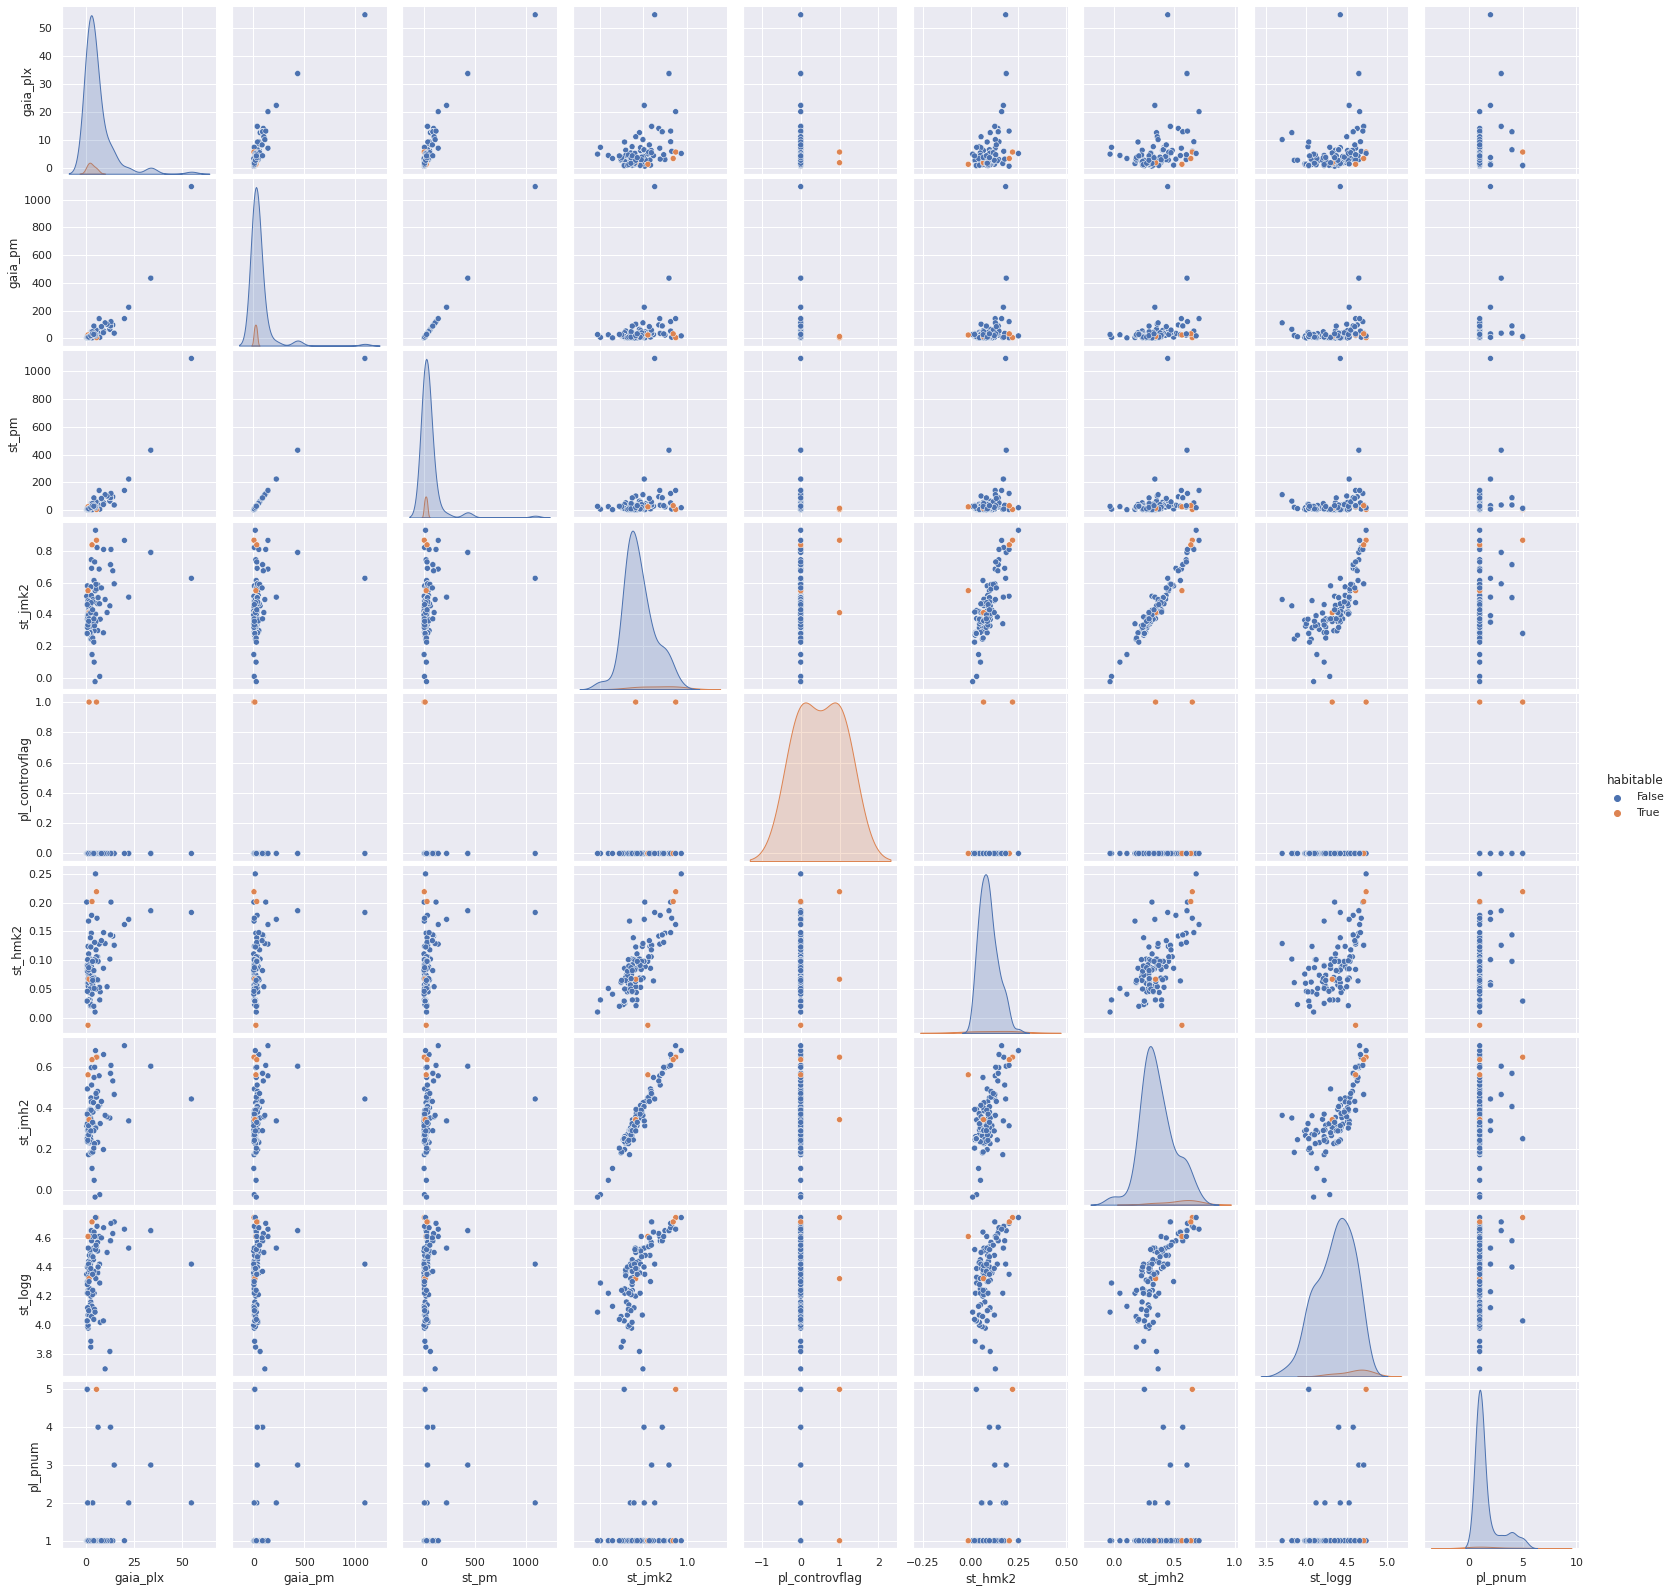

In [ ]:
# Positive ones
plt.figure(figsize = (15,7))
sns.pairplot(planets[['habitable', 'gaia_plx', 'gaia_pm', 'st_pm', 'st_jmk2', 'pl_controvflag',
                 'st_hmk2', 'st_jmh2', 'st_logg', 'pl_pnum']], hue='habitable')

In [ ]:
corr_df['habitable'].nsmallest(10)

pl_trandurerr2   -0.617398
pl_orbpererr2    -0.579690
pl_tranmiderr2   -0.560881
pl_rvflag        -0.414345
pl_rads          -0.249210
pl_rade          -0.249149
pl_radj          -0.248717
st_mass          -0.207312
st_teff          -0.202233
st_rad           -0.181490
Name: habitable, dtype: float64

<Figure size 1080x504 with 0 Axes>

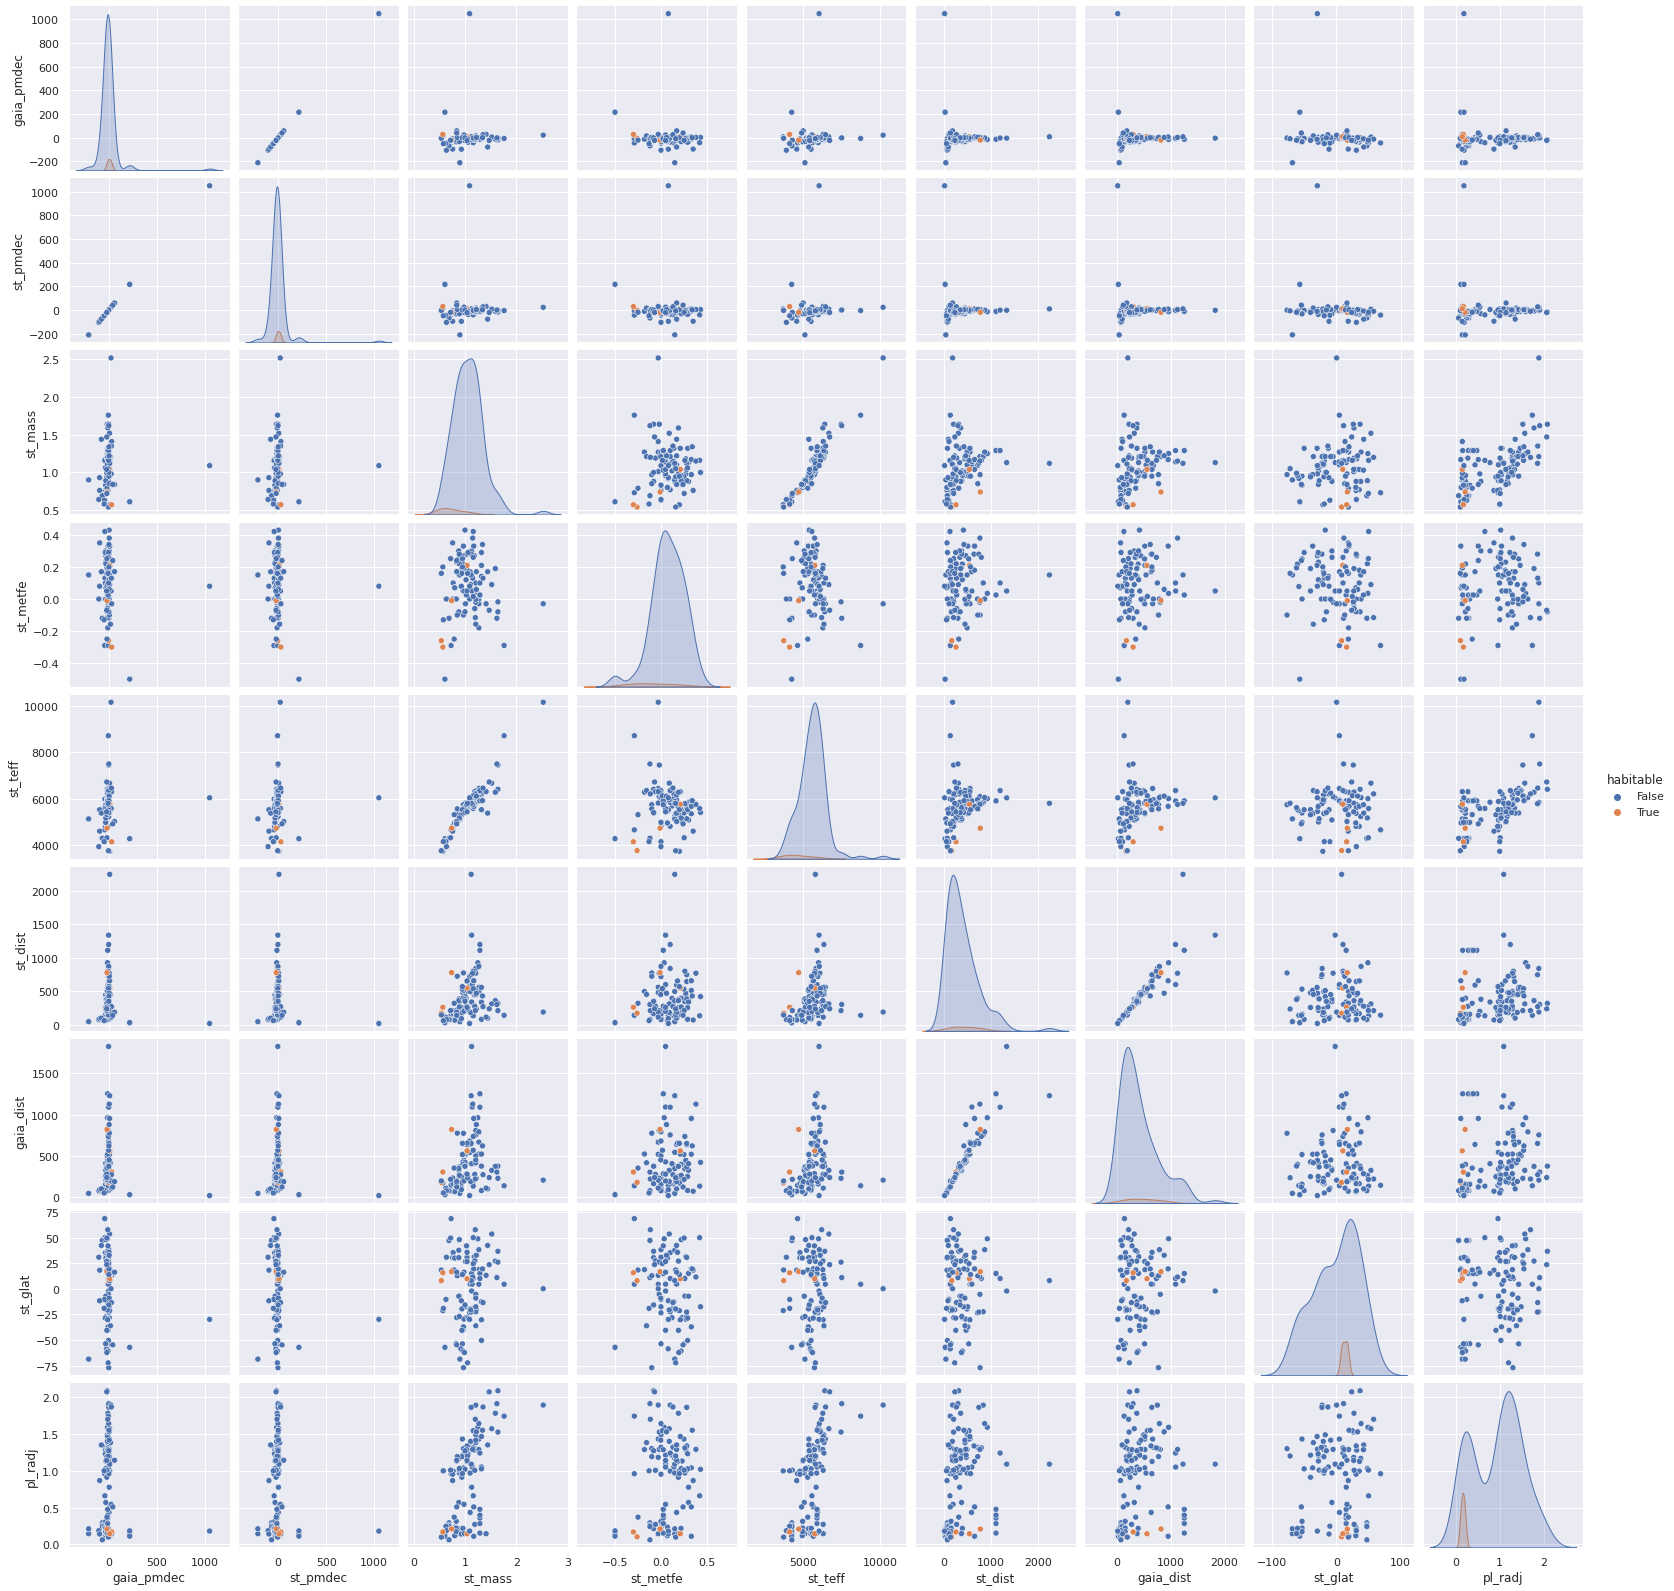

In [ ]:
# Negative ones
plt.figure(figsize = (15,7))
sns.pairplot(planets[['habitable', 'gaia_pmdec', 'st_pmdec', 'st_mass', 'st_metfe', 'st_teff',
                 'st_dist', 'gaia_dist', 'st_glat', 'pl_radj']], hue='habitable')

### Distance - Travel Time

In [ ]:
planets_c = planets[['st_dist', 'habitable', 'st_mass']]
planets_c.drop(planets_c[planets_c.habitable != 1].index, inplace=True)

In [ ]:
planets_c['dist_to_star_ly'] = planets_c['st_dist'] * 3.26
"""
The Voyager 1 spacecraft is on an interstellar mission. It is traveling away from the Sun at a rate of 17.3 km/s. It means
62280 km/h. 
1 light year = 9.4605284 × 10^12 kilometers
1 year = 8760 hours
1 speed of light = 1079252848.8 km/h
""" 
planets_c['minimum_travel_time_year'] = (((planets_c['dist_to_star_ly'] * 9.461e12) / 62280) / 8760)
planets_c.head()

,st_dist,habitable,st_mass,dist_to_star_ly,minimum_travel_time_year
rowid,,,,,
2223,172.0,True,0.54,560.72,9.723674e+06
2880,261.0,True,0.57,850.86,1.475511e+07
2883,779.0,True,0.74,2539.54,4.403920e+07
2902,548.0,True,1.04,1786.48,3.098008e+07


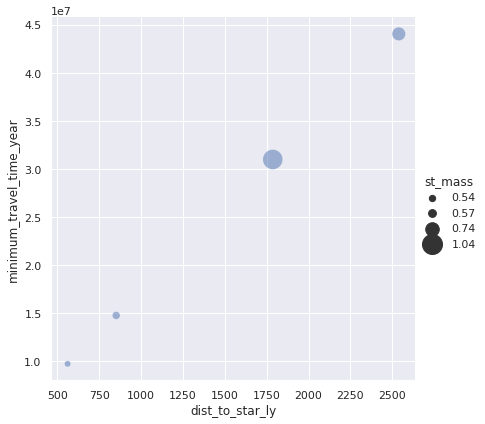

In [ ]:
sns.relplot(x="dist_to_star_ly", y="minimum_travel_time_year", size="st_mass",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=planets_c)

# Part 3: Heading to Machine Learning

## 1. Data Preparation 

### Drop Lowly Correlated Features 

In [ ]:
# corr_df had created in part-2
corr_df.tail(18)

,habitable
gaia_distlim,NaN
st_pmralim,NaN
st_pmdeclim,NaN
st_pmlim,NaN
gaia_pmralim,NaN
gaia_pmdeclim,NaN
gaia_pmlim,NaN
st_logglim,NaN
st_metfelim,NaN
st_jlim,NaN


These feature's correlation with habitability is "NaN" because each value of them are identical. That's why I got NaN as a correlation value.

In [ ]:
planets_c = planets.copy()

In [ ]:
cols_to_drop = ['st_distlim', 'gaia_distlim', 'st_optmaglim', 'gaia_gmaglim', 'st_masslim', 'st_radlim', 'pl_trandurlim', 
                'pl_tranmidlim', 'pl_mnum', 'gaia_plxlim', 'st_pmralim', 'st_pmdeclim', 'st_pmlim', 'gaia_pmralim', 
                'gaia_pmdeclim', 'gaia_pmlim', 'st_logglim', 'st_optband']
planets_c = planets_c.drop(cols_to_drop, axis=1)

In [ ]:
# Insert categorical features into the planets_c 
# Remove the '[' character and the ']' character from column names as it causes issues during training
# planets_c.st_metratio = planets_c.st_metratio.map(lambda x: x.replace("]",""))
# planets_c.st_metratio = planets_c.st_metratio.map(lambda x: x.replace("[",""))

# Encoding categorical features
# cols_encode = ['st_metratio']
# enc = TargetEncoder()
# planets_c[cols_encode] = enc.fit_transform(planets_c[cols_encode], planets_c['habitable'])
# planets_c[['st_metratio']] = planets_c[cols_encode]

In [ ]:
#Selecting highly correlated features
unrelevant_features = corr_df[corr_df['habitable'] <= 0.09]

to_drop = [column for column in unrelevant_features.index]
planets_c.drop(planets_c[to_drop[:97]], axis=1, inplace=True)

After some research, I decided to add these features to model's dataset: planet mass, planet's radial velocity amplitude [m/s], equilibrium temperature [K],planet radius [Earth radii], and orbital period [days]. But I have just planet radius and orbital period, there are so many missing data in the other features.

In [ ]:
planets_c[['pl_rade', 'pl_orbper']] = planets[['pl_rade', 'pl_orbper']]

In [ ]:
# Reorder columns
planets_c = planets_c[['pl_pnum', 'pl_controvflag', 'pl_rade', 'pl_orbper', 'st_teff',
                       'st_mass', 'st_pm', 'st_pmdec', 'st_metfe', 'st_logg', 'st_jmh2',
                       'st_jmk2', 'st_hmk2', 'gaia_plx', 'gaia_pm', 'gaia_pmdec', 'habitable']]
planets_c.describe()

KeyError: ignored

In [ ]:
# log transformation to decrease the effect of the outliers
log_cols = ['gaia_plx', 'st_pm', 'gaia_pm', 'st_teff', 'pl_rade', 'pl_orbper']
planets_c[log_cols] = (planets_c[log_cols]+1).transform(np.log)

KeyError: ignored

In [ ]:
norm_cols = ['st_pmdec', 'gaia_pmdec']
planets_c[norm_cols] = preprocessing.normalize(planets_c[norm_cols])

KeyError: ignored

In [ ]:
planets_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 65 to 3957
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pl_controvflag  117 non-null    int64  
 1   pl_orbper       117 non-null    float64
 2   pl_orbpererr1   117 non-null    float64
 3   pl_orbperlim    117 non-null    float64
 4   pl_orbsmaxlim   117 non-null    float64
 5   pl_radjerr2     117 non-null    float64
 6   pl_radjlim      117 non-null    float64
 7   pl_kepflag      117 non-null    int64  
 8   ra              117 non-null    float64
 9   dec             117 non-null    float64
 10  st_optmag       117 non-null    float64
 11  gaia_gmag       117 non-null    float64
 12  st_tefferr1     117 non-null    float64
 13  st_tefflim      117 non-null    float64
 14  pl_tranflag     117 non-null    int64  
 15  pl_imgflag      117 non-null    int64  
 16  pl_astflag      117 non-null    float64
 17  pl_cbflag       117 non-null    i

In [ ]:
planets_c.drop('pl_discmethod', inplace=True, axis=1)
planets_c.drop('st_metratio', inplace=True, axis=1)

KeyError: ignored

In [ ]:
planets_c.drop('st_metratio', inplace=True, axis=1)

### SMOTE - Over Sampling 

In [ ]:
# Basic validation: splitting the data 60 - 20 - 20 train/val/test
X_train, X_test, y_train, y_test = train_test_split(planets_c.iloc[:, :-1], planets_c.loc[:, 'habitable'], test_size=0.25,random_state=76)
X_train.shape 
# shape of my train set

(87, 56)

In [ ]:
# from imblearn.over_sampling import SMOTE


# oversample = SMOTE()
# X_smoted, y_smoted = oversample.fit_resample(X, y)
# Resampling imbalanced data
X_smoted, y_smoted = SMOTE( sampling_strategy='minority',k_neighbors=2, random_state=76).fit_resample(X_train, y_train)


In [ ]:
X_smoted.shape

(168, 56)

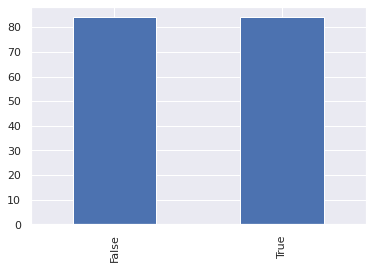

In [ ]:
# observe that data has been balanced
pd.Series(y_smoted).value_counts().plot.bar()

In [ ]:
# list to contain model and accuracy values
eva_list = []
# to contain model names
models = []

## 2. Machine Learning Models

### 2.1. Logistic Regression 

In [ ]:
lr = LogisticRegression()
lr.fit(X_smoted, y_smoted)
y_pred_l = lr.predict(X_test)

lr_acc = round(lr.score(X_smoted, y_smoted) * 100, 2)
lr_acc_test = round(accuracy_score(y_test, y_pred_l) * 100, 2)
print(f'Train Accuracy of Logistic Regression: % {lr_acc}')
print(f'Test Accuracy of Logistic Regression: % {lr_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred_l, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of Logistic Regression: % 99.4
Test Accuracy of Logistic Regression: % 93.33
Precision : 0.4827586206896552
Recall : 0.4827586206896552
F1-score : 0.4827586206896552


In [ ]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', round(lr_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.2. Linear SVC

In [ ]:
svc = SVC(kernel='linear', gamma=0.001, C=100, probability=True)
svc.fit(X_smoted, y_smoted)
y_pred_s = svc.predict(X_test)

svc_acc = round(svc.score(X_smoted, y_smoted) * 100, 2)
svc_acc_test = round(accuracy_score(y_test, y_pred_s) * 100, 2)

print(f'Train Accuracy Score of LinearSVC: % {svc_acc}')
print(f'Test Accuracy Score of LinearSVC: % {svc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred_s, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of LinearSVC: % 100.0
Test Accuracy Score of LinearSVC: % 96.67
Precision : 0.48333333333333334
Recall    : 0.5
F1-score   : 0.4915254237288135


In [ ]:
eva_list.append(dict([
    ('Model', 'Linear SVC'),
    ('Train Accuracy', round(svc_acc, 2)),
    ('Test Accuracy', round(svc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.3. K-Nearest Neighbors 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_smoted, y_smoted)
y_pred = knn.predict(X_test)

knn_acc = round(knn.score(X_smoted, y_smoted) * 100, 2)
knn_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy of KNN: % {knn_acc}')
print(f'Test Accuracy of KNN: % {knn_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of KNN: % 99.4
Test Accuracy of KNN: % 100.0
Precision : 1.0
Recall : 1.0
F1-score : 1.0


In [ ]:
eva_list.append(dict([
    ('Model', 'K-Nearest Neighbors'),
    ('Train Accuracy', round(knn_acc, 2)),
    ('Test Accuracy', round(knn_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.4. Naive Bayes

In [ ]:
nbg = GaussianNB()
nbg.fit(X_smoted, y_smoted)
y_pred_n = nbg.predict(X_test)

nbg_acc=round(nbg.score(X_smoted, y_smoted) * 100, 2)
nbg_acc_test=round(accuracy_score(y_test, y_pred_n) * 100, 2)

print(f'Train Accuracy Score of GaussianNB: % {nbg_acc}')
print(f'Test Accuracy Score of GaussianNB: % {nbg_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred_n, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of GaussianNB: % 100.0
Test Accuracy Score of GaussianNB: % 100.0
Precision : 1.0
Recall    : 1.0
F1-score   : 1.0


In [ ]:
eva_list.append(dict([
    ('Model', 'Gaussian Naive Bayes'),
    ('Train Accuracy', round(nbg_acc, 2)),
    ('Test Accuracy', round(nbg_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.5. Decision Trees 

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_smoted, y_smoted)
y_pred = dt.predict(X_test)

dt_acc = round(dt.score(X_smoted, y_smoted) * 100, 2)
dt_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Decision Trees: % {dt_acc}')
print(f'Test Accuracy Score of Decision Trees: % {dt_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Decision Trees: % 100.0
Test Accuracy Score of Decision Trees: % 100.0
Precision : 1.0
Recall    : 1.0
F1-score   : 1.0


In [ ]:
eva_list.append(dict([
    ('Model', 'Decision Trees'),
    ('Train Accuracy', round(dt_acc, 2)),
    ('Test Accuracy', round(dt_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [ ]:
# View feature importances
importances_dt = pd.DataFrame({'feature': X_train.columns,
                             'importance': dt.feature_importances_})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt.head(16)

,importance
feature,
habitable,1.0
pl_orbper,0.0
st_plxlim,0.0
gaia_plxerr2,0.0
st_logg,0.0
st_metfelim,0.0
st_j,0.0
st_jlim,0.0
st_h,0.0


### 2.6. Random Forest 

In [ ]:
num_estimator = 100
seed = 7
rf = RandomForestClassifier(n_estimators=num_estimator)
rf.fit(X_smoted, y_smoted)
y_predr = rf.predict(X_test)

rf_acc = round(rf.score(X_smoted, y_smoted) * 100, 2)
rf_acc_test = round(accuracy_score(y_test, y_predr) * 100, 2)
print(f'Train Accuracy Score of Random Forest: % {rf_acc}')
print(f'Test Accuracy Score of Random Forest: % {rf_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_predr, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Random Forest: % 100.0
Test Accuracy Score of Random Forest: % 96.67
Precision : 0.48333333333333334
Recall    : 0.5
F1-score   : 0.4915254237288135


In [ ]:
eva_list.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', round(rf_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [ ]:
# View feature importances
importances_rf = pd.DataFrame({'feature': X_train.columns,
                             'importance': rf.feature_importances_})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(16)

,importance
feature,
habitable,0.206074
pl_orbper,0.172781
pl_trandur,0.102214
pl_trandurerr1,0.088517
pl_orbpererr1,0.055321
st_wise4,0.051180
st_wise2,0.045327
pl_tranmiderr1,0.037039
st_wise3,0.033620


### 2.7. Stochastic Gradient Boosting Classifier 

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=num_estimator, learning_rate=0.01,
                                random_state=seed)
gbc.fit(X_smoted, y_smoted)
y_pred_g = gbc.predict(X_test)

gbc_acc = round(gbc.score(X_smoted, y_smoted) * 100, 2)
gbc_acc_test = round(accuracy_score(y_test, y_pred_g) * 100, 2)
print(f'Train Accuracy Score of Gradient Boosting: % {gbc_acc}')
print(f'Test Accuracy Score of Gradient Boosting: % {gbc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred_g, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Gradient Boosting: % 100.0
Test Accuracy Score of Gradient Boosting: % 100.0
Precision : 1.0
Recall    : 1.0
F1-score   : 1.0


In [ ]:
eva_list.append(dict([
    ('Model', 'Stochastic Gradient Boosting Classifier'),
    ('Train Accuracy', round(gbc_acc, 2)),
    ('Test Accuracy', round(gbc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 2.8. AdaBoost Classifier 

In [ ]:
abc = AdaBoostClassifier(base_estimator=rf, n_estimators=num_estimator, random_state = seed)
abc.fit(X_smoted, y_smoted)
y_pred = abc.predict(X_test)

abc_acc = round(abc.score(X_smoted, y_smoted) *100 , 2)
abc_acc_test = round(accuracy_score(y_test, y_pred) * 100 ,2)

print(f'Train Accuracy Score of AdaBoostClassifier: % {abc_acc}')
print(f'Test Accuracy Score of AdaBoostClassifier: % {abc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Train Accuracy Score of AdaBoostClassifier: % 100.0
Test Accuracy Score of AdaBoostClassifier: % 100.0
Precision : 1.0
Recall    : 1.0
F1-score   : 1.0


In [ ]:
eva_list.append(dict([
    ('Model', 'AdaBoost Classifier'),
    ('Train Accuracy', round(abc_acc, 2)),
    ('Test Accuracy', round(abc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

### 2.9. Voting Algorithms 

In [ ]:
# Hard Voting
vc_hard = VotingClassifier(
    estimators=[('lr', lr), ('nb',nbg), ('rf', rf), ('gbc', gbc)],
    voting = 'hard')

vc_hard.fit(X_smoted, y_smoted)
y_pred = vc_hard.predict(X_test)

vch_acc = round(vc_hard.score(X_smoted, y_smoted) * 100, 2)
vch_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of Hard VotingClassifier: % {vch_acc}')
print(f'Test Accuracy Score of Hard VotingClassifier: % {vch_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Train Accuracy Score of Hard VotingClassifier: % 100.0
Test Accuracy Score of Hard VotingClassifier: % 100.0
Precision : 1.0
Recall    : 1.0
F1-score   : 1.0


In [ ]:
eva_list.append(dict([
    ('Model', 'Hard Voting'),
    ('Train Accuracy', round(vch_acc, 2)),
    ('Test Accuracy', round(vch_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

### 2.10. XGBoost

In [ ]:
xgboost = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)

xgboost.fit(X_smoted, y_smoted)
y_predx = xgboost.predict(X_test)

xg_acc = round(xgboost.score(X_smoted, y_smoted) * 100, 2)
xg_acc_test = round(accuracy_score(y_test, y_predx) * 100, 2)

print(f'Train Accuracy Score of Hard VotingClassifier: % {xg_acc}')
print(f'Test Accuracy Score of Hard VotingClassifier: % {xg_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1score, support = score(y_test, y_predx, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Train Accuracy Score of Hard VotingClassifier: % 100.0
Test Accuracy Score of Hard VotingClassifier: % 100.0
Precision : 1.0
Recall    : 1.0
F1-score   : 1.0


In [ ]:
eva_list.append(dict([
    ('Model', 'XGBoost'),
    ('Train Accuracy', round(xg_acc, 2)),
    ('Test Accuracy', round(xg_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

## 3. Evaluation

### Performance list of models

In [ ]:
results = pd.DataFrame(data=eva_list)
results = results[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
results = results.sort_values(by='Recall', ascending=False)
results = results.set_index('Model')
results

,Train Accuracy,Test Accuracy,Precision,Recall,F1
Model,,,,,
K-Nearest Neighbors,99.4,100.00,1.00,1.00,1.00
K-Nearest Neighbors,99.4,100.00,1.00,1.00,1.00
Gaussian Naive Bayes,100.0,100.00,1.00,1.00,1.00
Decision Trees,100.0,100.00,1.00,1.00,1.00
Stochastic Gradient Boosting Classifier,100.0,100.00,1.00,1.00,1.00
AdaBoost Classifier,100.0,100.00,1.00,1.00,1.00
Hard Voting,100.0,100.00,1.00,1.00,1.00
XGBoost,100.0,100.00,1.00,1.00,1.00
Linear SVC,100.0,96.67,0.48,0.50,0.49


### Confusion Matrix 

In [ ]:
conf_xg = confusion_matrix(y_test, y_predx)
conf_svc = confusion_matrix(y_test, y_pred_s)

def conf_matrix(x):
    plt.figure(dpi=125)
    sns.heatmap(x, cmap=plt.cm.Reds, annot=True, square=True,fmt='d',
               xticklabels=['not habitable', 'habitable'],
               yticklabels=['not habitable', 'habitable'])

    plt.xlabel('Predicted planets')
    plt.ylabel('Actual planets')

Text(0.5, 1.0, 'Confusion Matrix of XGBoost')

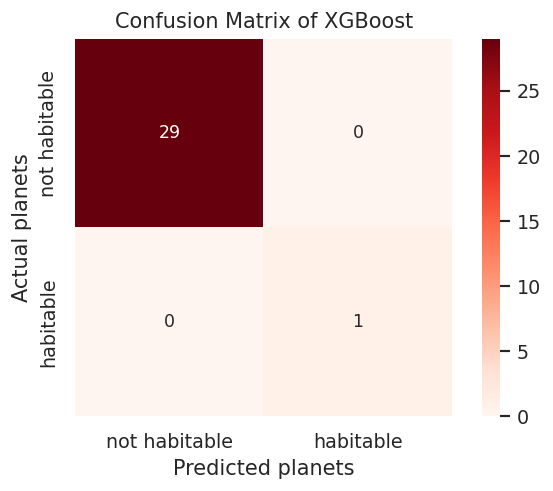

In [ ]:
conf_matrix(conf_xg)
plt.title('Confusion Matrix of XGBoost')

Text(0.5, 1.0, 'Confusion Matrix of Linear SVC')

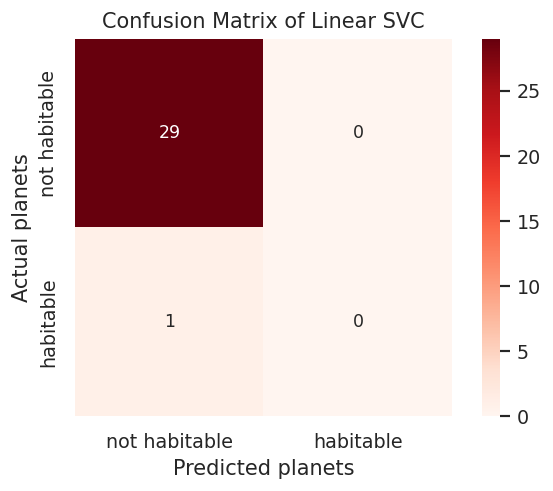

In [ ]:
conf_matrix(conf_svc)
plt.title('Confusion Matrix of Linear SVC')

### Optimization of the Model 

#### XGBoost - GridSearchCV

In [ ]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}

In [ ]:
kf=KFold(n_splits=10, shuffle=True, random_state=76)
xgb_grid = GridSearchCV(xgboost, param_grid=parameters, cv=kf, scoring='recall', n_jobs=-1)
xgb_grid.fit(X_smoted, y_smoted)

GridSearchCV(cv=KFold(n_splits=10, random_state=76, shuffle=True),
             estimator=XGBClassifier(colsample_bytree=0.4, gamma=10,
                                     learning_rate=0.01, max_depth=4,
                                     n_estimators=1000, reg_alpha=0.3,
                                     silent=False, subsample=0.8),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='recall')

In [ ]:
y_pred_x = xgb_grid.predict(X_test)

opt_xgb_test = round(accuracy_score(y_test, y_pred_x) * 100, 2)
print(f'Test Accuracy Score of Logistic Regression: % {opt_xgb_test}')

precision, recall, f1score, support = score(y_test, y_pred_x, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Test Accuracy Score of Logistic Regression: % 100.0
Precision : 1.0
Recall    : 1.0
F1-score   : 1.0


In [ ]:
# examine the best model
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60}
XGBClassifier(colsample_bytree=0.4, gamma=10, max_depth=2, n_estimators=60,
              reg_alpha=0.3, silent=False, subsample=0.8)


### Evaluation Graphs 

ROC AUC score =  1.0


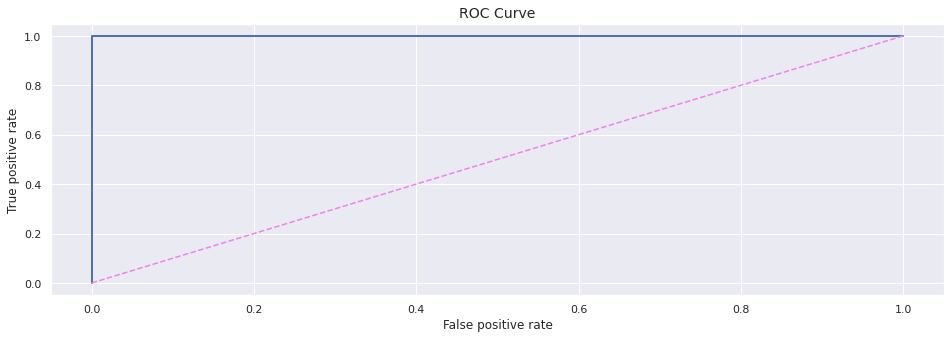

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_grid.predict_proba(X_test)[:,1])

plt.figure(figsize = (16,5))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve', fontsize=14)
print("ROC AUC score = ", roc_auc_score(y_test, xgb_grid.predict_proba(X_test)[:,1]))

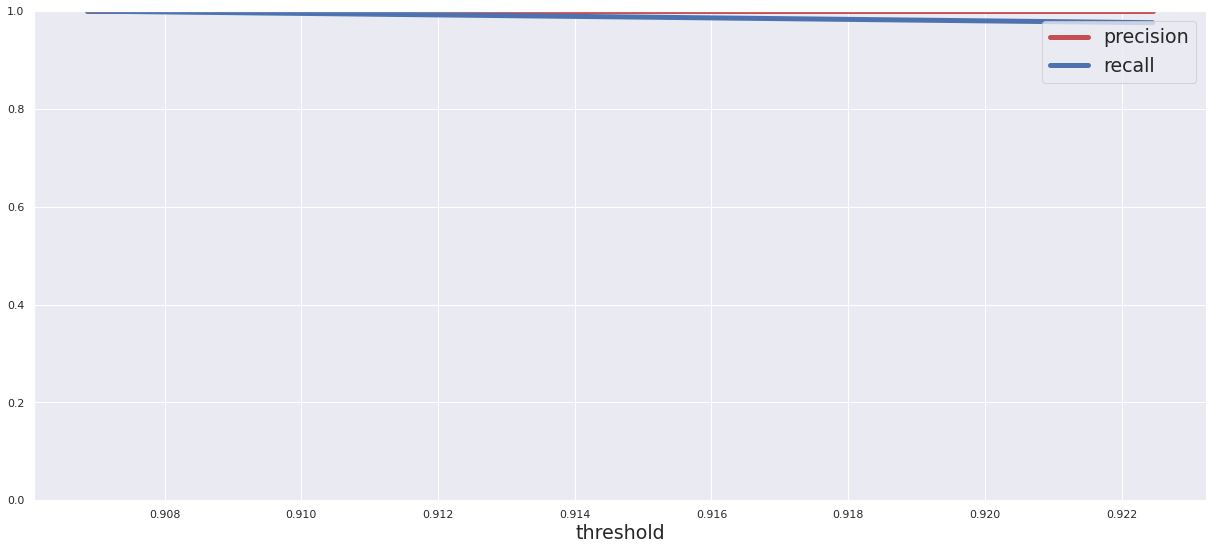

In [ ]:
y_scores = xgb_grid.predict_proba(X_smoted)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_smoted, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])
    

plt.figure(figsize = (21, 9))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

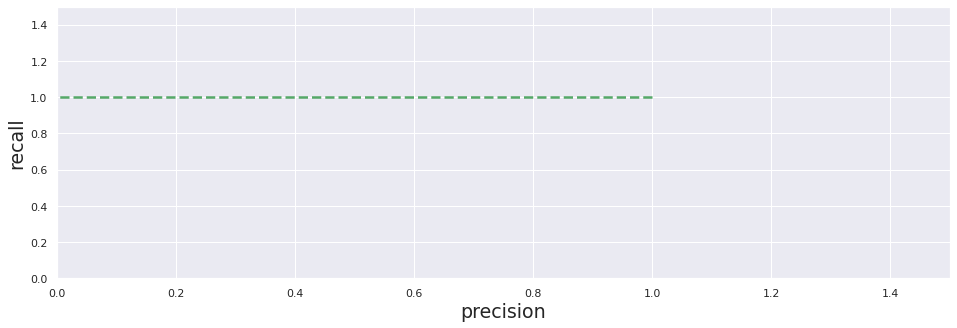

In [ ]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize = (16,5))
plot_precision_vs_recall(precision, recall)
plt.show()

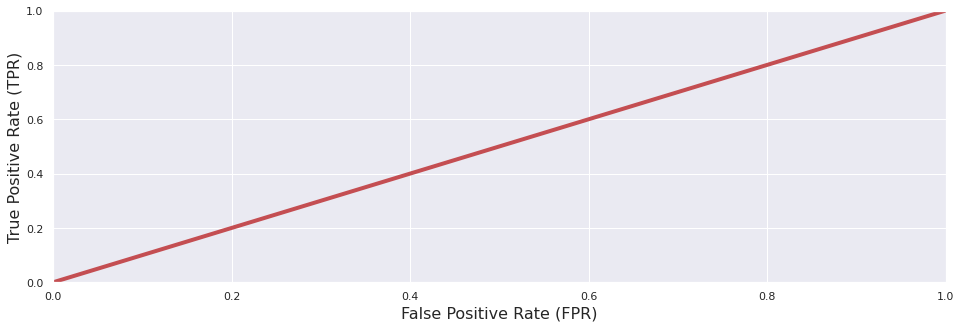

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_smoted, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize = (16,5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

Text(0.5, 1.0, 'Precision and Recall Curves')

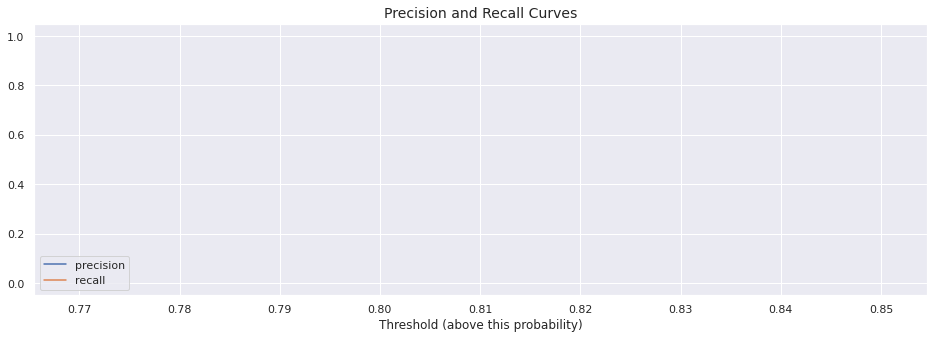

In [ ]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, xgb_grid.predict_proba(X_test)[:,1] )

plt.figure(figsize = (16,5))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability)')
plt.title('Precision and Recall Curves', fontsize=14)

In [ ]:
# saving model
pickle.dump(xgb_grid, open("Flask/model.pkl","wb"))

FileNotFoundError: ignored